In [41]:
import pandas as pd # standard
import numpy as np # standard
from sklearn import tree # package to make decision tree
from sklearn.metrics import accuracy_score # for accuracy calculation
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import thermogram_utilities

import warnings
warnings.filterwarnings("ignore")


In [8]:
df = pd.read_excel("/Users/avery/OneDrive/Documents/GitHub/Clinical_TLB_2023-2024/lung_cancer_tlb.xlsx")

# replace NA with control
df['CancerType'] = np.where(df['CancerType'].isna(), 'Control', df['CancerType'])

# keep only Control and Adenocarcinoma for analysis
df_tree = df[(df['CancerType'] == 'Control') | (df['CancerType'] == 'Adenocarcinoma')]
df_tree = df_tree.reset_index(drop=True)

In [9]:
# length of df
num_rows = df_tree.shape[0]

# number of bootstraps
total_bootstraps = 15

# create results df
hyperparameter_tuning_df = pd.DataFrame(columns=["max_depth", "max_features", 'min_leaves', "balanced_accuracy", 'auc'])
best_combination_df = pd.DataFrame(columns=["max_depth", "max_features", 'min_leaves', "balanced_accuracy", 'auc'])

# create array of all indices in full data set
all_indices = np.arange(num_rows)

# columns to drop
drop_cols = ['sample_id', 'pub_id', 'CancerType']

# loop to bootstrap and validate many times
for i in range(total_bootstraps):

    hyperparameter_tuning_df = pd.DataFrame(columns=["max_depth", "max_features", 'min_leaves', "balanced_accuracy", 'auc'])

    # sample indices with replacement of df
    train_indices = np.random.choice(num_rows, num_rows, replace = True)
    # get the train set using the indices
    train_set = df_tree.iloc[train_indices, : ]
    # get the indices not selected
    test_indices = np.setdiff1d(all_indices, train_indices)
    # use not selected indices as the train set
    test_set = df_tree.iloc[test_indices, : ]

    for depth in range(1, 16):
        for features in range(1, 452, 5):
            for leaves in range(1,6):

                # initialize decision tree
                clf = tree.DecisionTreeClassifier(max_depth= depth, max_features=features, min_samples_leaf= leaves)

                # train and test tree
                clf = clf.fit( train_set.drop(drop_cols, axis = 1), train_set['CancerType'])
                test_predictions = clf.predict(test_set.drop(drop_cols, axis = 1))

                # calculate balanced accuracy
                balanced_acc = balanced_accuracy_score(test_set['CancerType'], test_predictions)

                # get probabilities
                test_probabilities = clf.predict_proba(test_set.drop(drop_cols, axis = 1))

                # test decision tree
                test_predictions = clf.predict(test_set.drop(drop_cols, axis = 1))

                # calculate weighted accuracy
                balanced_acc = balanced_accuracy_score(test_set['CancerType'], test_predictions)

                # calculate AUC
                auc = roc_auc_score(test_set['CancerType'] == 'Control', test_probabilities[:, 1])

                # append to results df
                hyperparameter_tuning_df.loc[len(hyperparameter_tuning_df)] = [depth, features, leaves, balanced_acc, auc]

    
    best_combination_df = pd.concat([best_combination_df, hyperparameter_tuning_df.sort_values('balanced_accuracy', ascending=False).head(1)])



C:\Users\avery\AppData\Local\Temp\ipykernel_14236\1892828419.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  best_combination_df = pd.concat([best_combination_df, hyperparameter_tuning_df.sort_values('balanced_accuracy', ascending=False).head(1)])


In [30]:

best_combination_df.sort_values('balanced_accuracy', ascending=False).head(5)

best_combination_df.to_excel("BSCV_Results.xlsx")


,max_depth,max_features,min_leaves,balanced_accuracy,auc
6041,14.0,126.0,2.0,0.826087,0.806238
3650,9.0,11.0,1.0,0.824405,0.824405
3686,9.0,46.0,2.0,0.820513,0.850427
1377,4.0,11.0,3.0,0.814935,0.852814
4572,11.0,21.0,3.0,0.808421,0.810526


In [32]:
best_combination_df.sort_values('balanced_accuracy', ascending=False).head(1)

max_depth = int(best_combination_df.sort_values('balanced_accuracy', ascending=False).iloc[0, 0])
max_features = int(best_combination_df.sort_values('balanced_accuracy', ascending=False).iloc[0, 1])
min_leaves = int(best_combination_df.sort_values('balanced_accuracy', ascending=False).iloc[0, 2])
print(max_depth, max_features, min_leaves)

clf = tree.DecisionTreeClassifier(max_depth= max_depth, max_features=max_features, min_samples_leaf= min_leaves)

# train and test tree
clf = clf.fit( df_tree.drop(drop_cols, axis = 1), df_tree['CancerType'])

feature_importance1 = clf.feature_importances_

temps = df_tree.drop(['CancerType', 'sample_id', 'pub_id'], axis = 1).columns.str.replace('T', '')
temps = temps.astype(float)
feature_importance = pd.DataFrame({"Temperature":temps, "Importance": feature_importance1})

14 126 2


In [35]:
df_long = pd.melt(df_tree, id_vars=['sample_id', 'pub_id', 'CancerType'], var_name='temp', value_name='dsp' )

median_df = thermogram_utilities.median_curve(df_long, 'CancerType', 'temp', 'dsp')

median_df['temperature'] = median_df['temperature'].str.replace('T', '').astype(float)

c:\Users\avery\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\avery\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\avery\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\avery\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

Text(0.5, 1.0, 'Temperature and Importance')

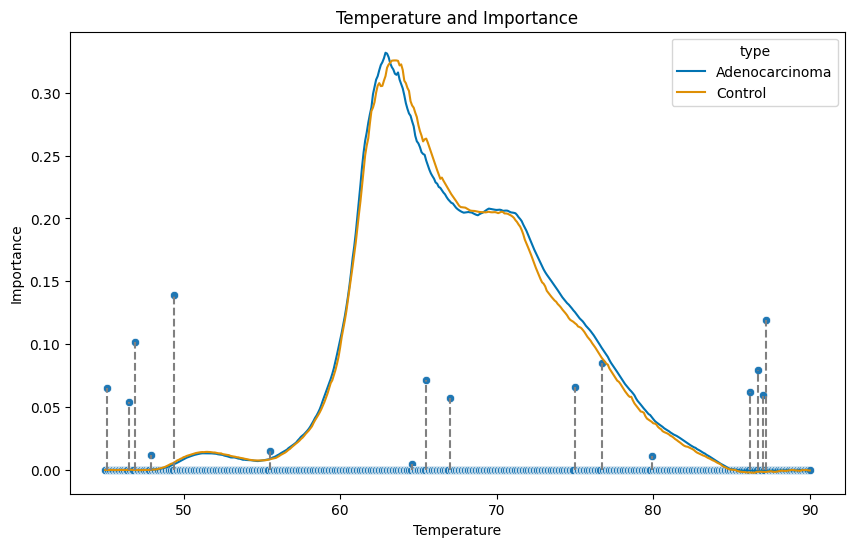

In [40]:
# pivot variable importance df to long
plt.figure(figsize=(10, 6))

# create a bar plot
sns.scatterplot(data=feature_importance, x='Temperature', y='Importance')
p = sns.lineplot(data=median_df, x='temperature', y='median', hue='type', palette='colorblind')

for index, row in feature_importance.iterrows():
    x_value = row['Temperature']
    y_value = row['Importance']
    
    # Add a vertical line from the point to the x-axis
    plt.plot([x_value, x_value], [0, y_value], color='gray', linestyle='--')


# add labels and title
plt.xlabel('Temperature')
plt.ylabel('Importance')
plt.title('Temperature and Importance')

In [43]:
df_tree.shape

(123, 454)